아달린은 계산된 출려과 진짜 클래스 레이블 사이의 $\textbf{제곱오차합,SSE}$ 으로 가중치를 학습할 비용 함수 $\mathit{J}$를 정의 합니다. 

$$\mathit{J}(w) = \frac{1}{2}\sum_i(y^{(i)}-\phi(z^{(i)}))^2$$

단위 계단 함수 대신 연속적인 선형 활성화 함수를 사용하는 장점은 비용 함수가 미분 가능해진다는 것입니다. $\textbf{경사하강법(gradient descent)}$ 을 사용하면 비용 함수 $\mathit{J}(w)$ 의 그래디언트 $\nabla\mathit{J}(w)$ 반대 방향으로 조금씩 가중치를 업데이트 합니다.

$$ w := w + \Delta w $$

각 가중치 $w_j$에 대한 편도 함수를 계산해야 한다. 

$$ \frac{\partial\mathit{J}}{\partial w_j} = -\sum_i(y^{(i)}-\phi(z^{(i)}))x_j^{(i)} $$

$$ \Delta w_j = -\eta \frac{\partial\mathit{J}}{\partial w_j} = \eta\sum_i(y^{(i)}-\phi(z^{(i)}))x_j^{(i)} $$

훈련세트에 있는 모든 샘플을 기반으로 가중치 업데이트를 계산한다. 이 방식을 $\textbf{배치 경사 하강법}$ 이라고 한다. 

In [3]:
from matplotlib.colors import ListedColormap
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
y = df.iloc[0:100,4].values
y = np.where( y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values


def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black' 
                   )

        

In [2]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >=0.0, 1, -1)
    
    

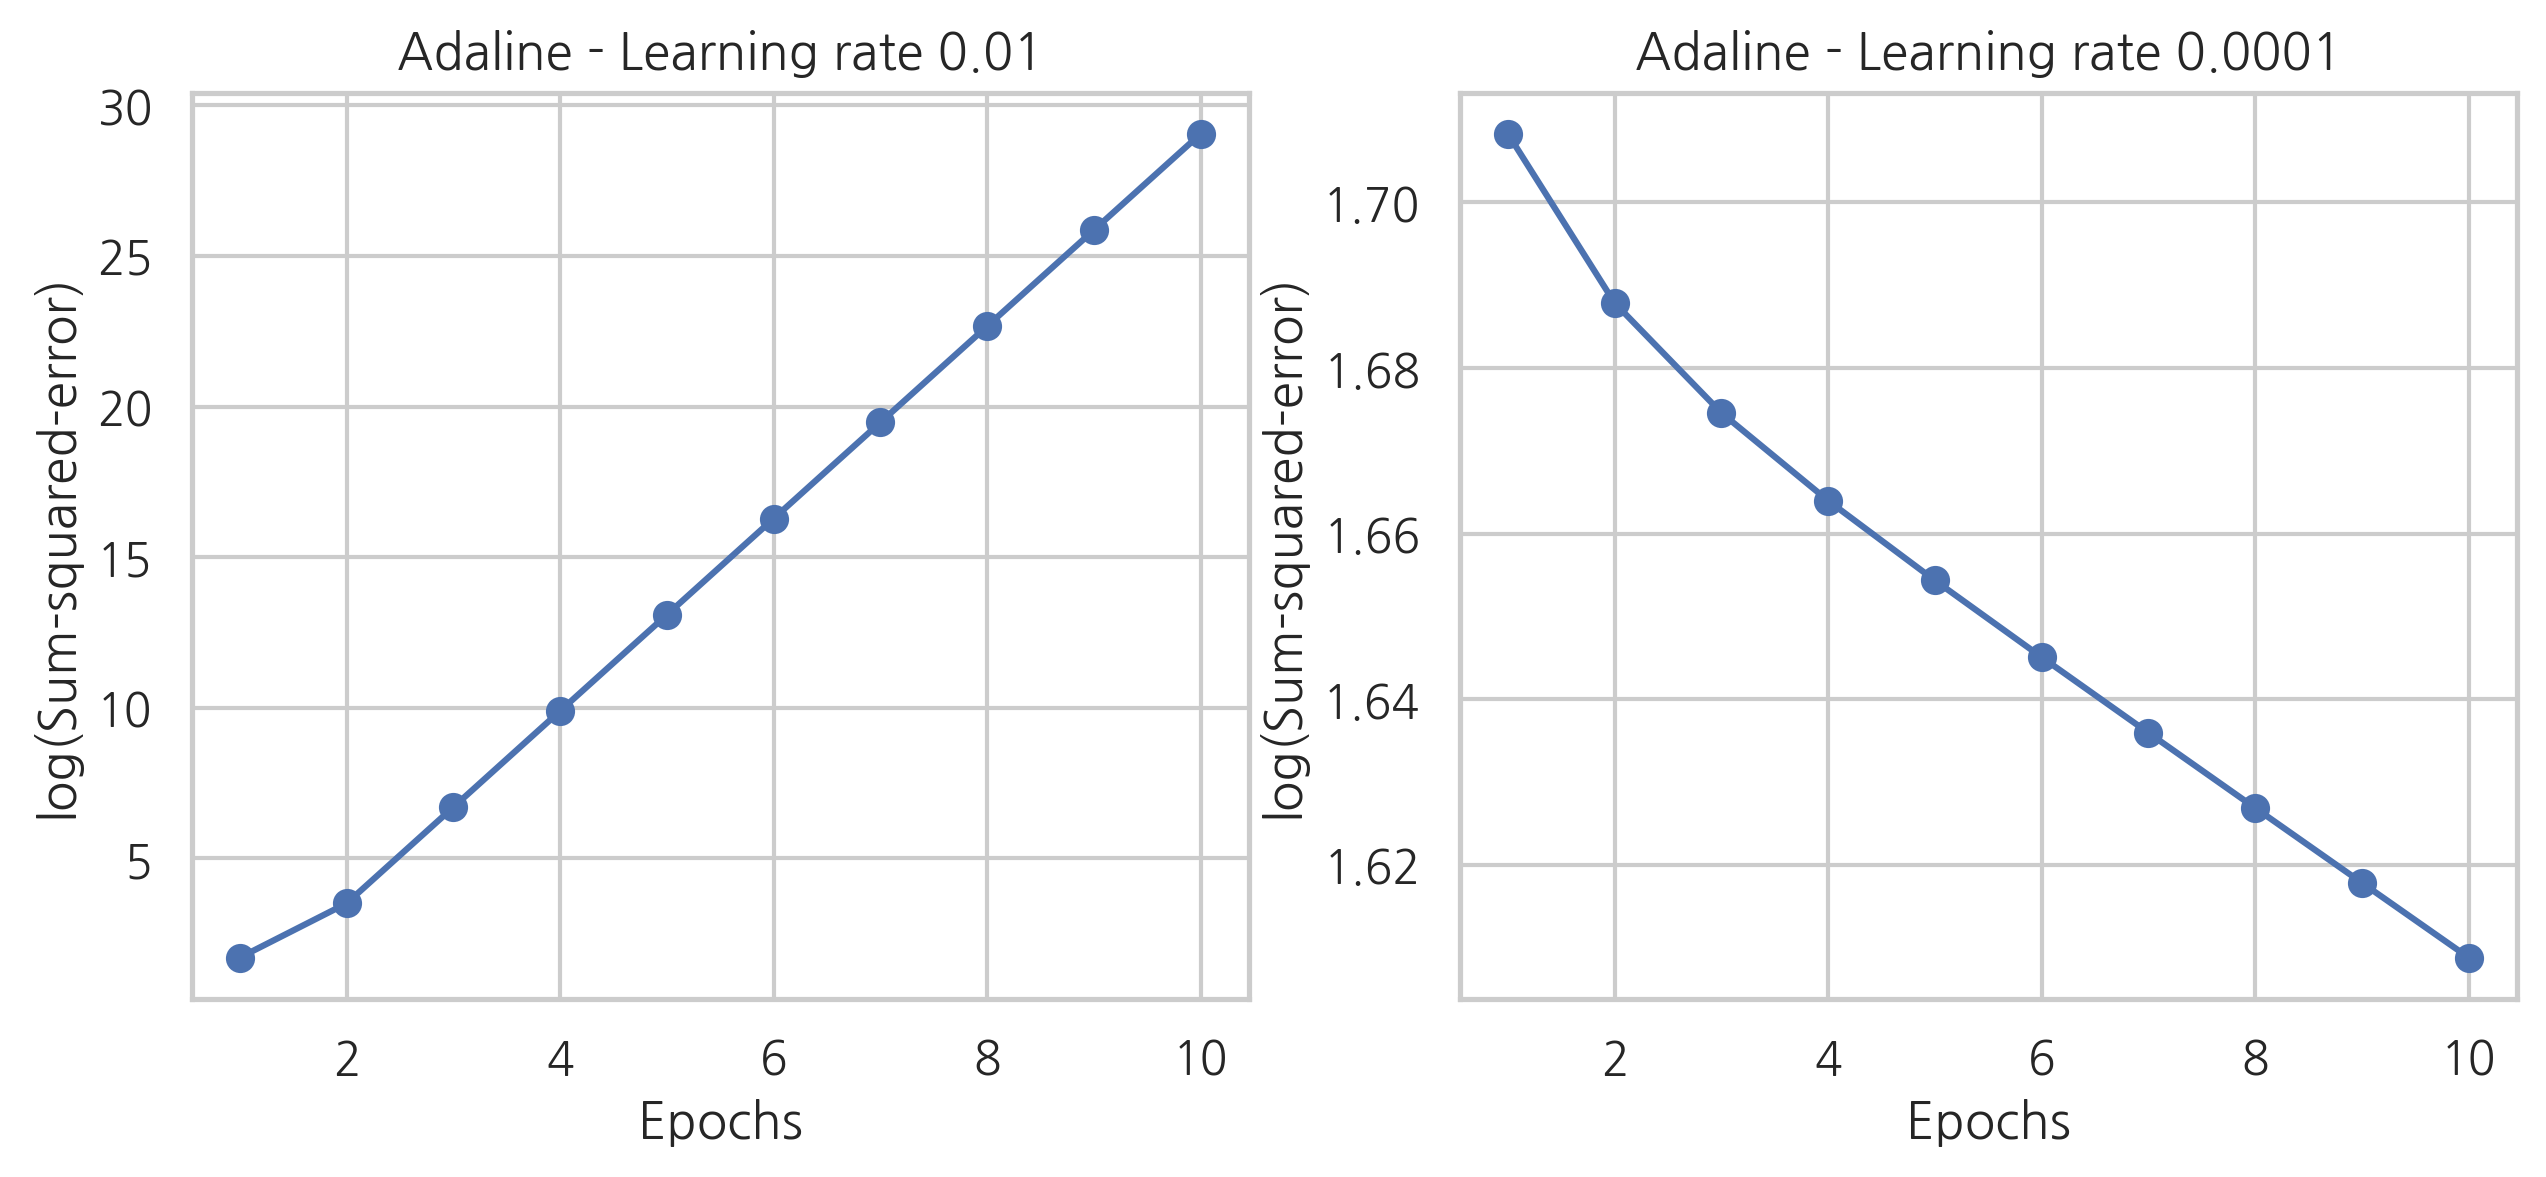

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()



### 특성 스케일 조정 (표준화)

표준화 

$$ x_j^{'} = \frac{x_j - \mu _j}{\sigma _j}$$

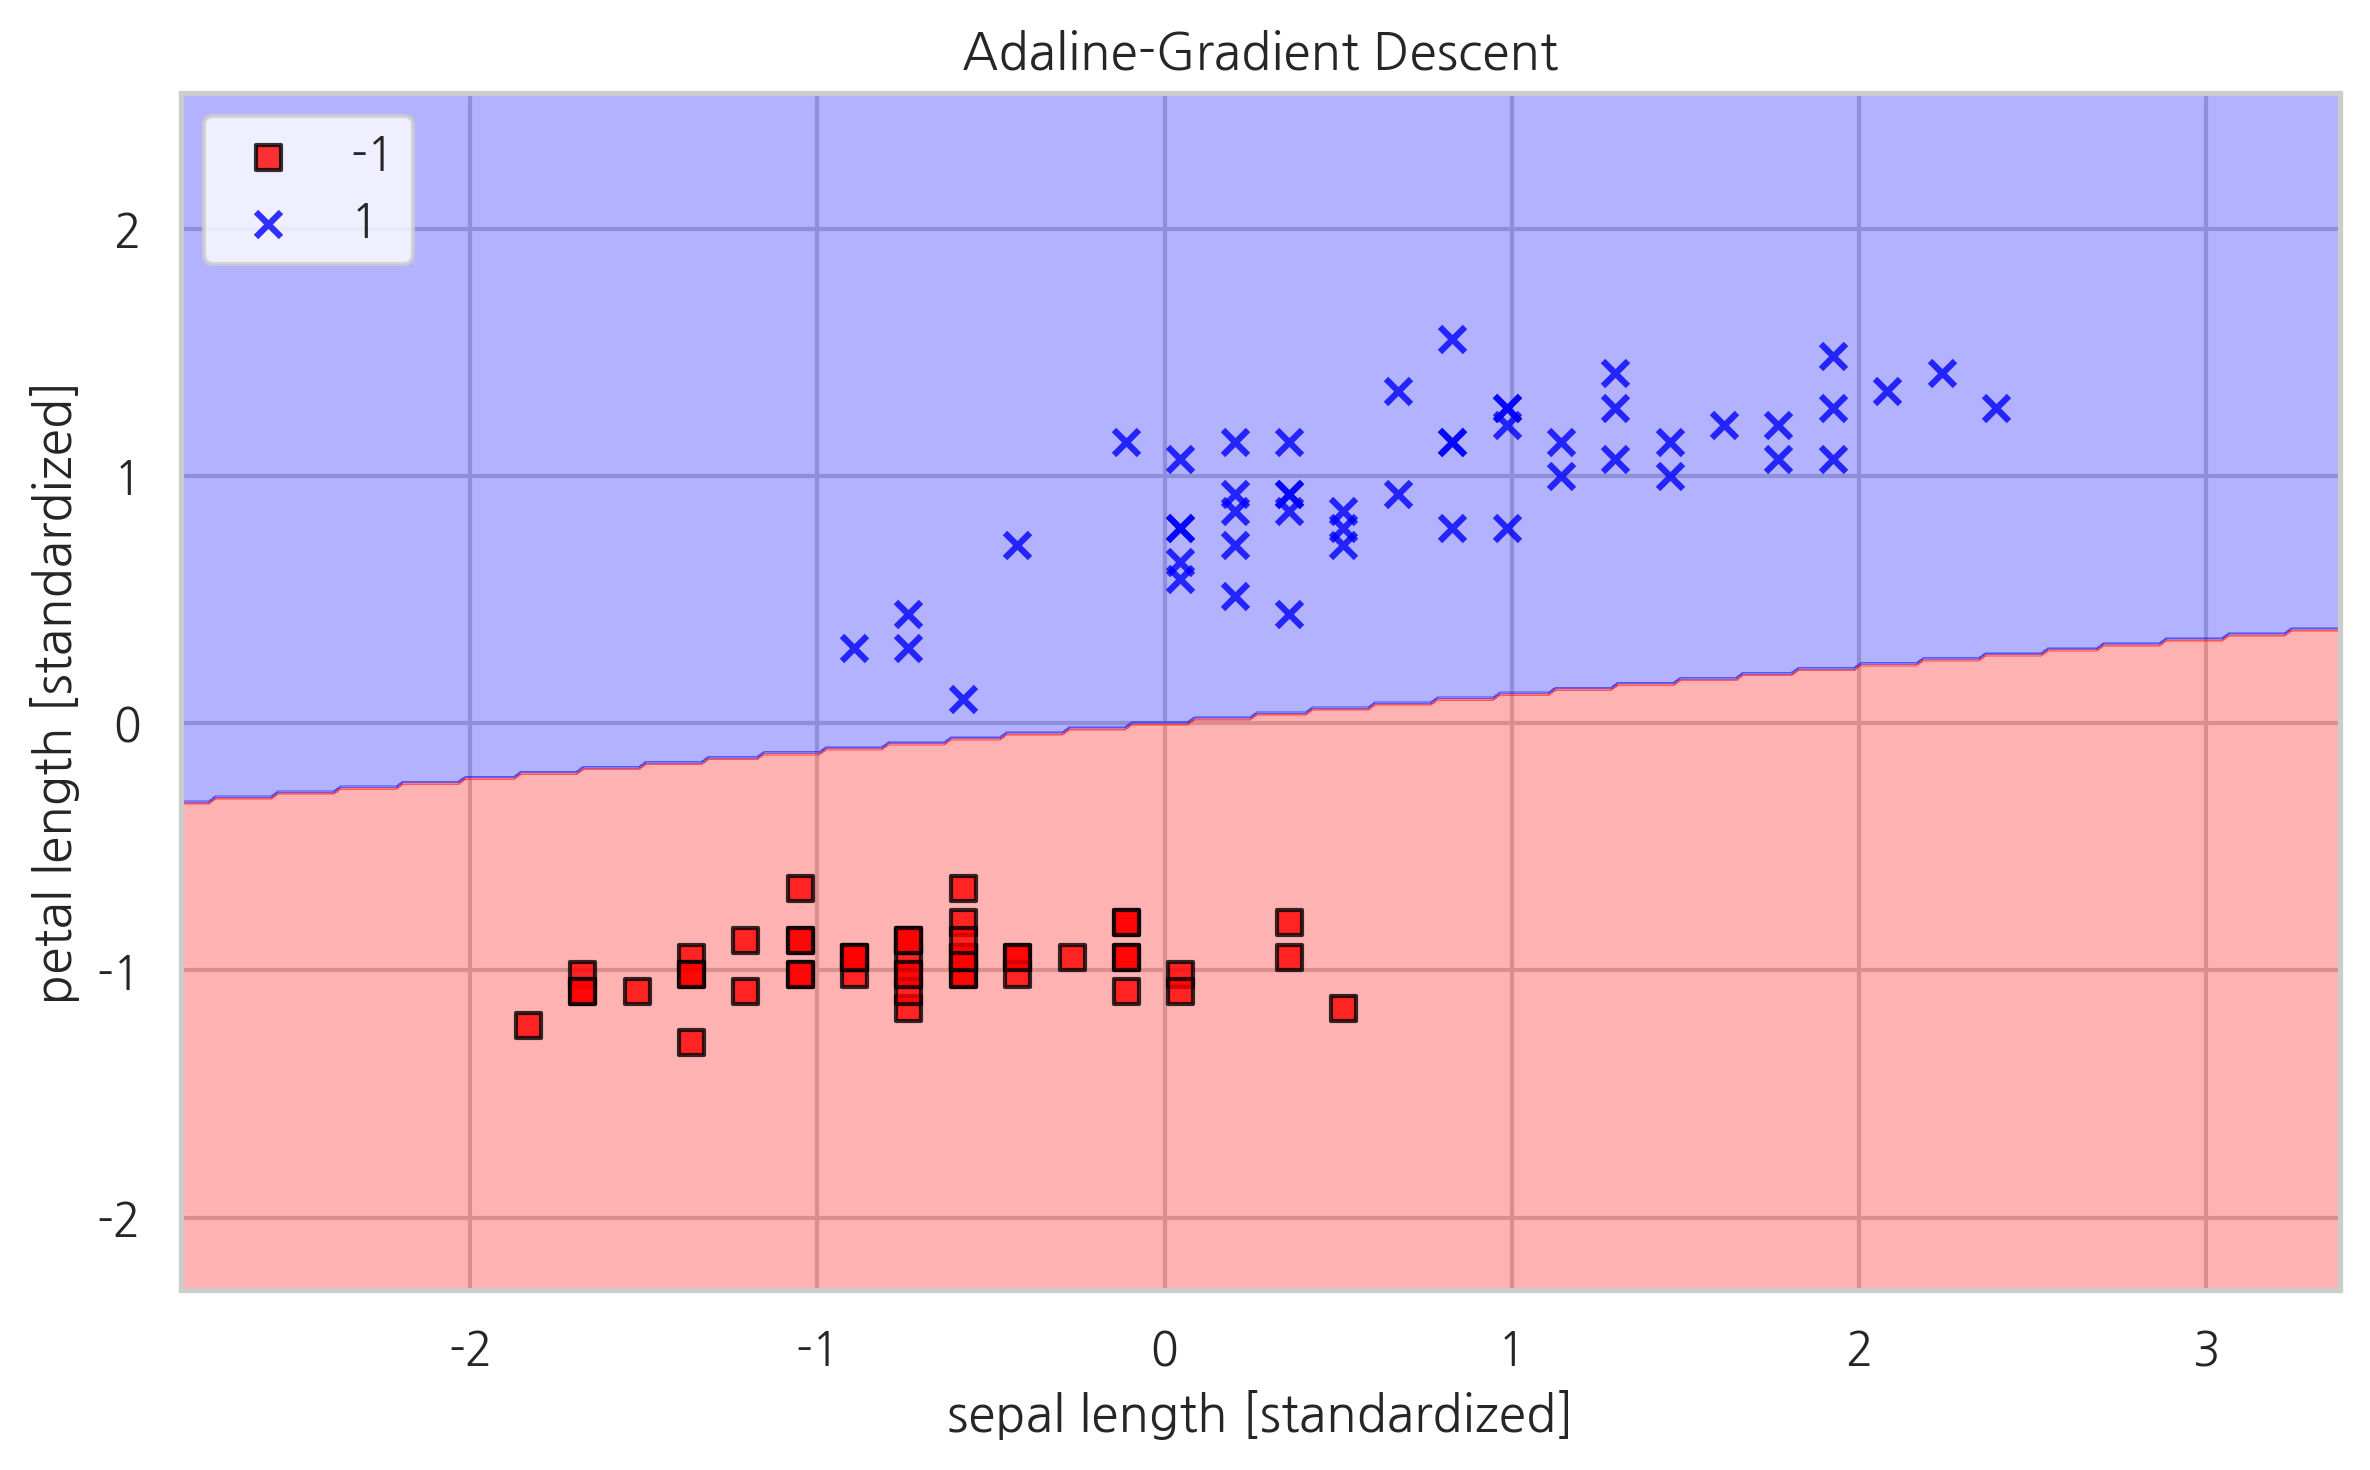

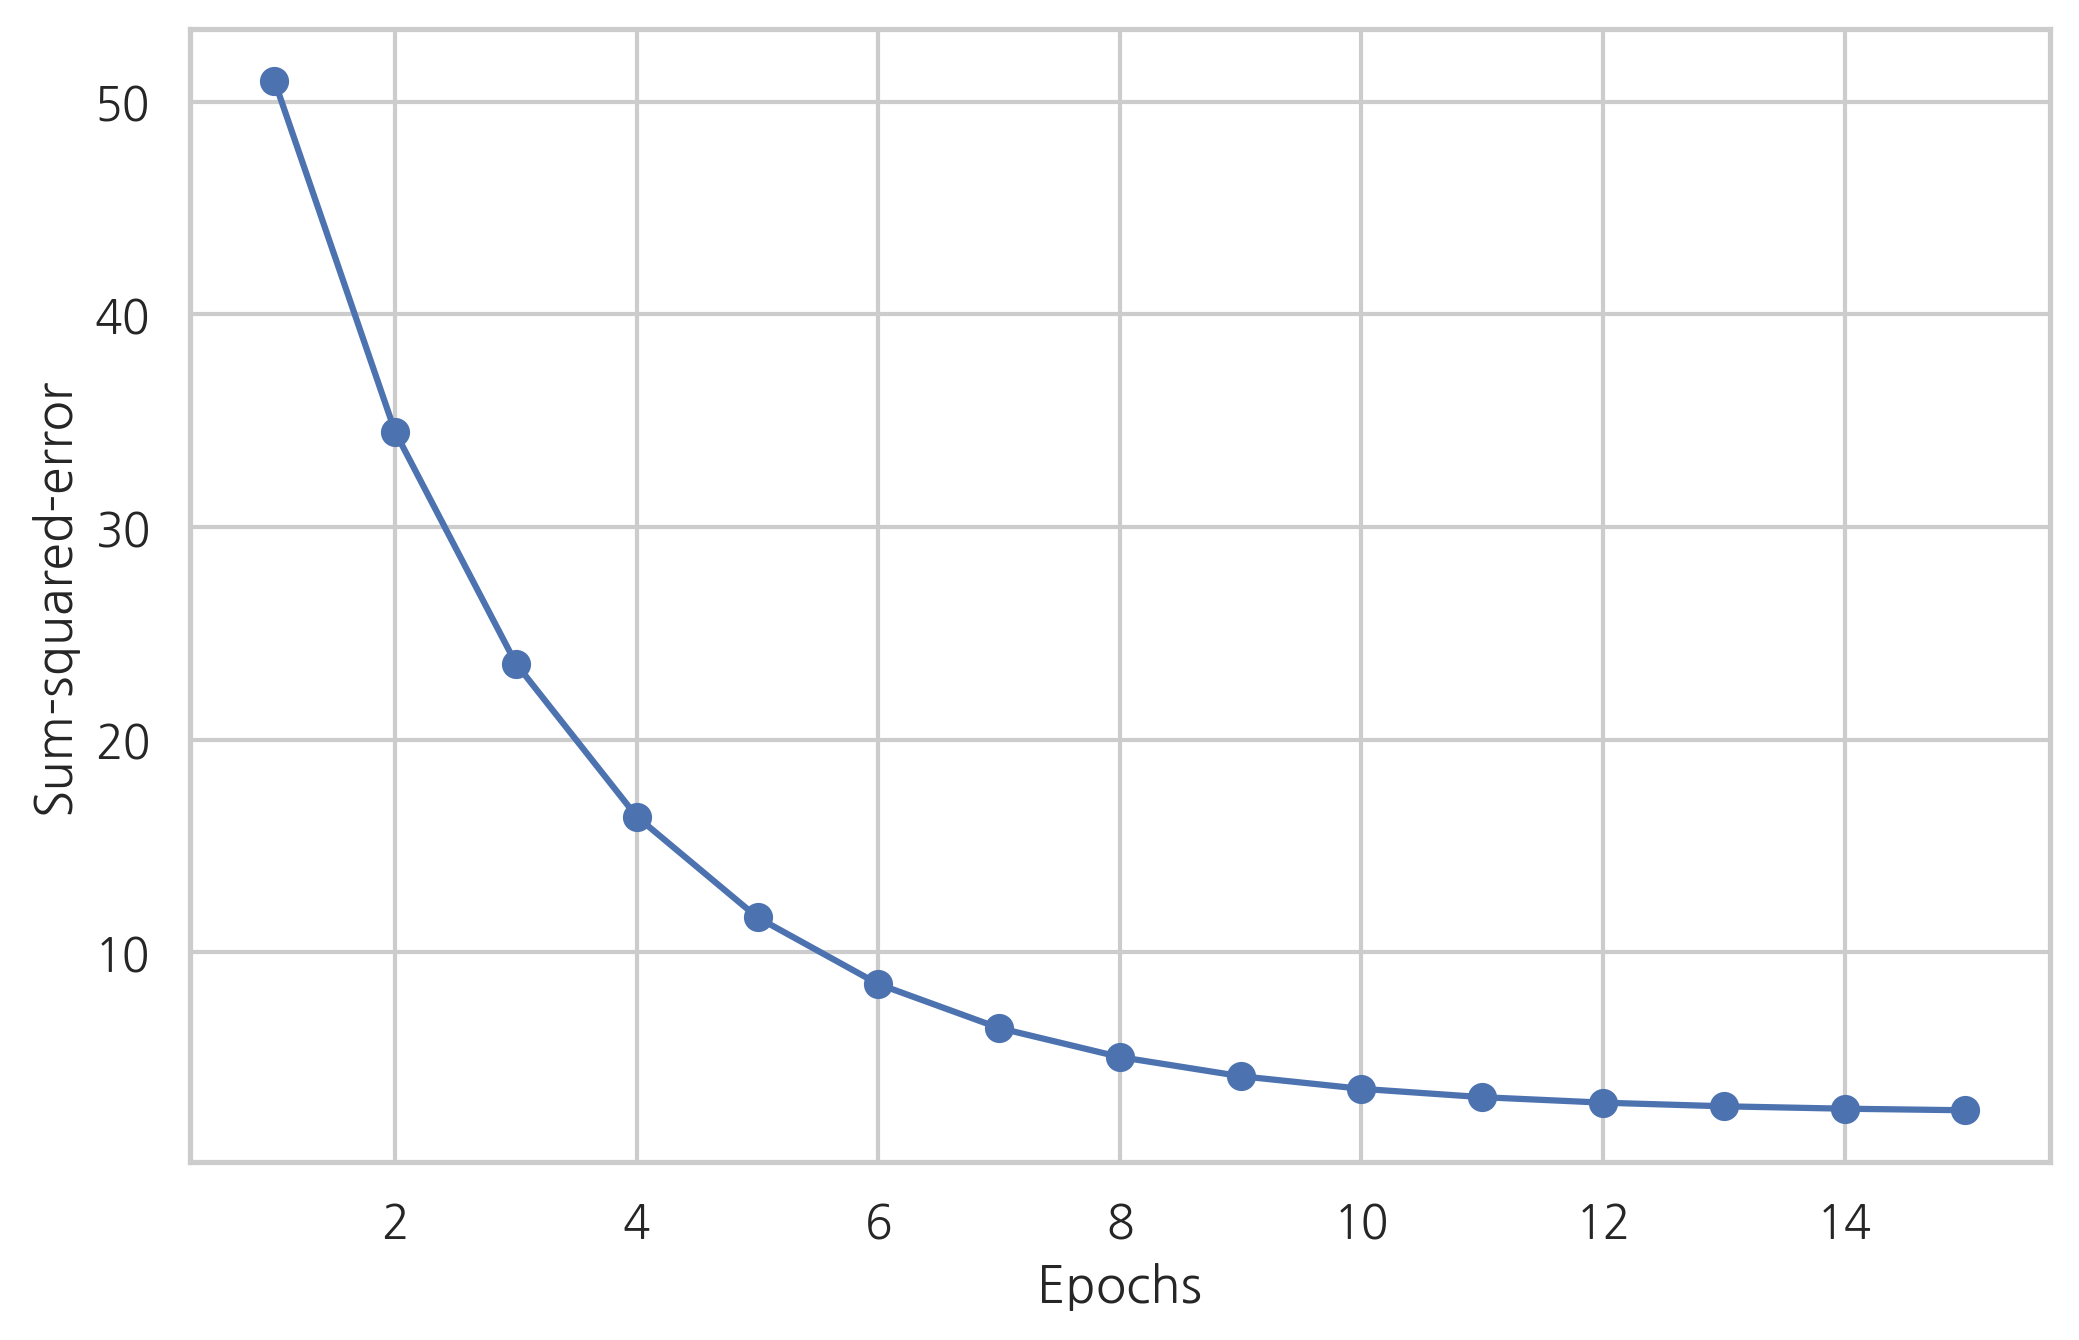

In [5]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean())/ X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean())/ X[:,1].std()
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std,y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline-Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()

In [6]:
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01,size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >=0.0, 1, -1)
    


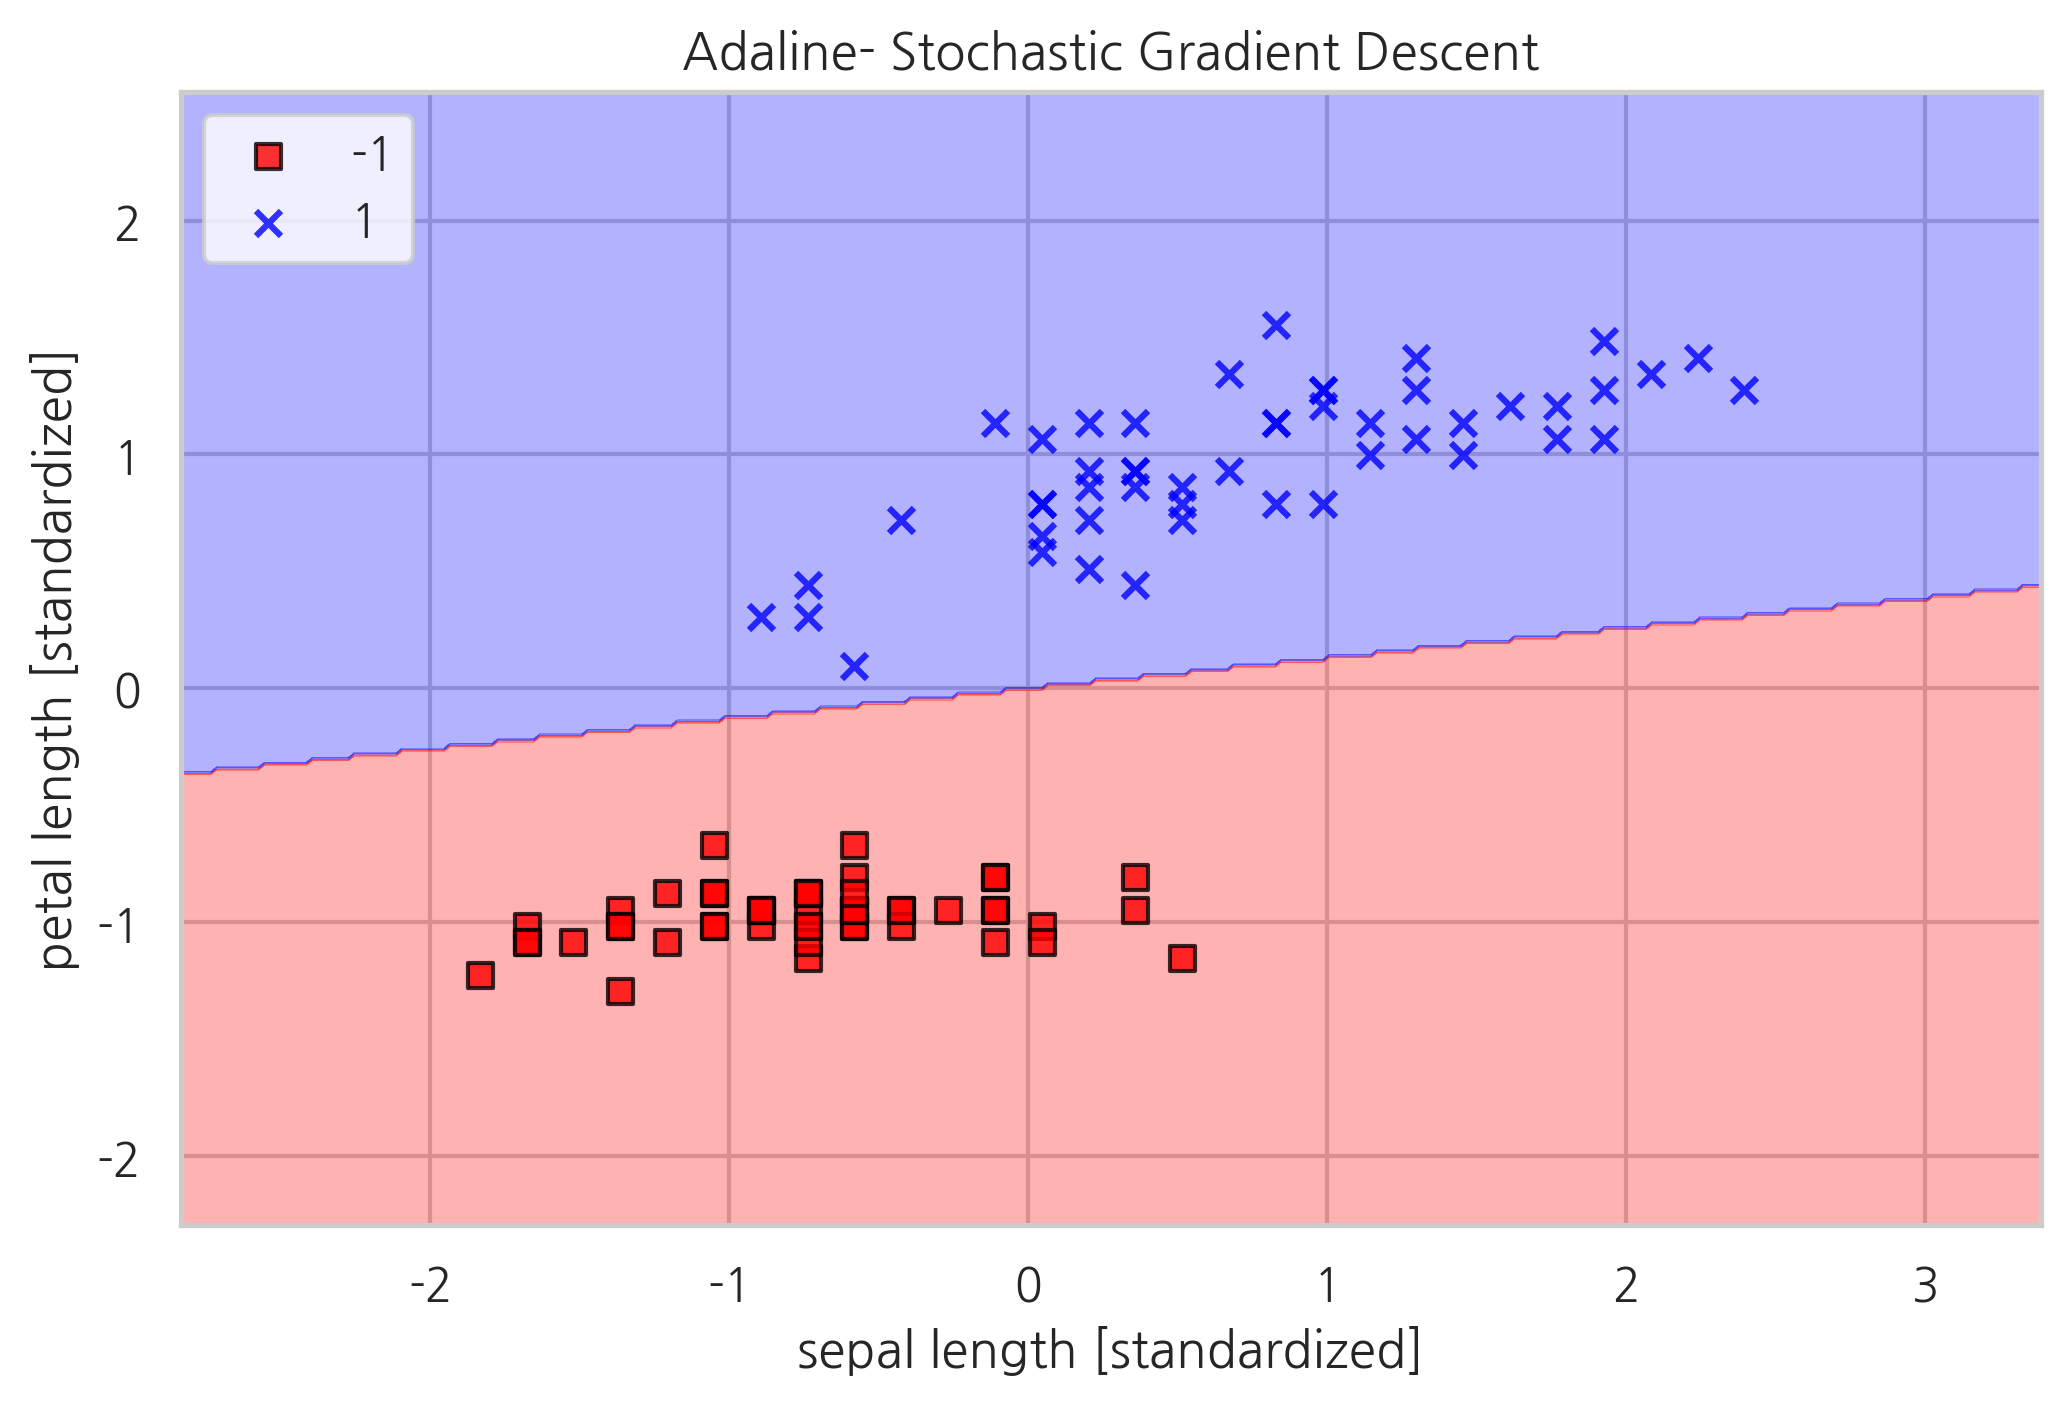

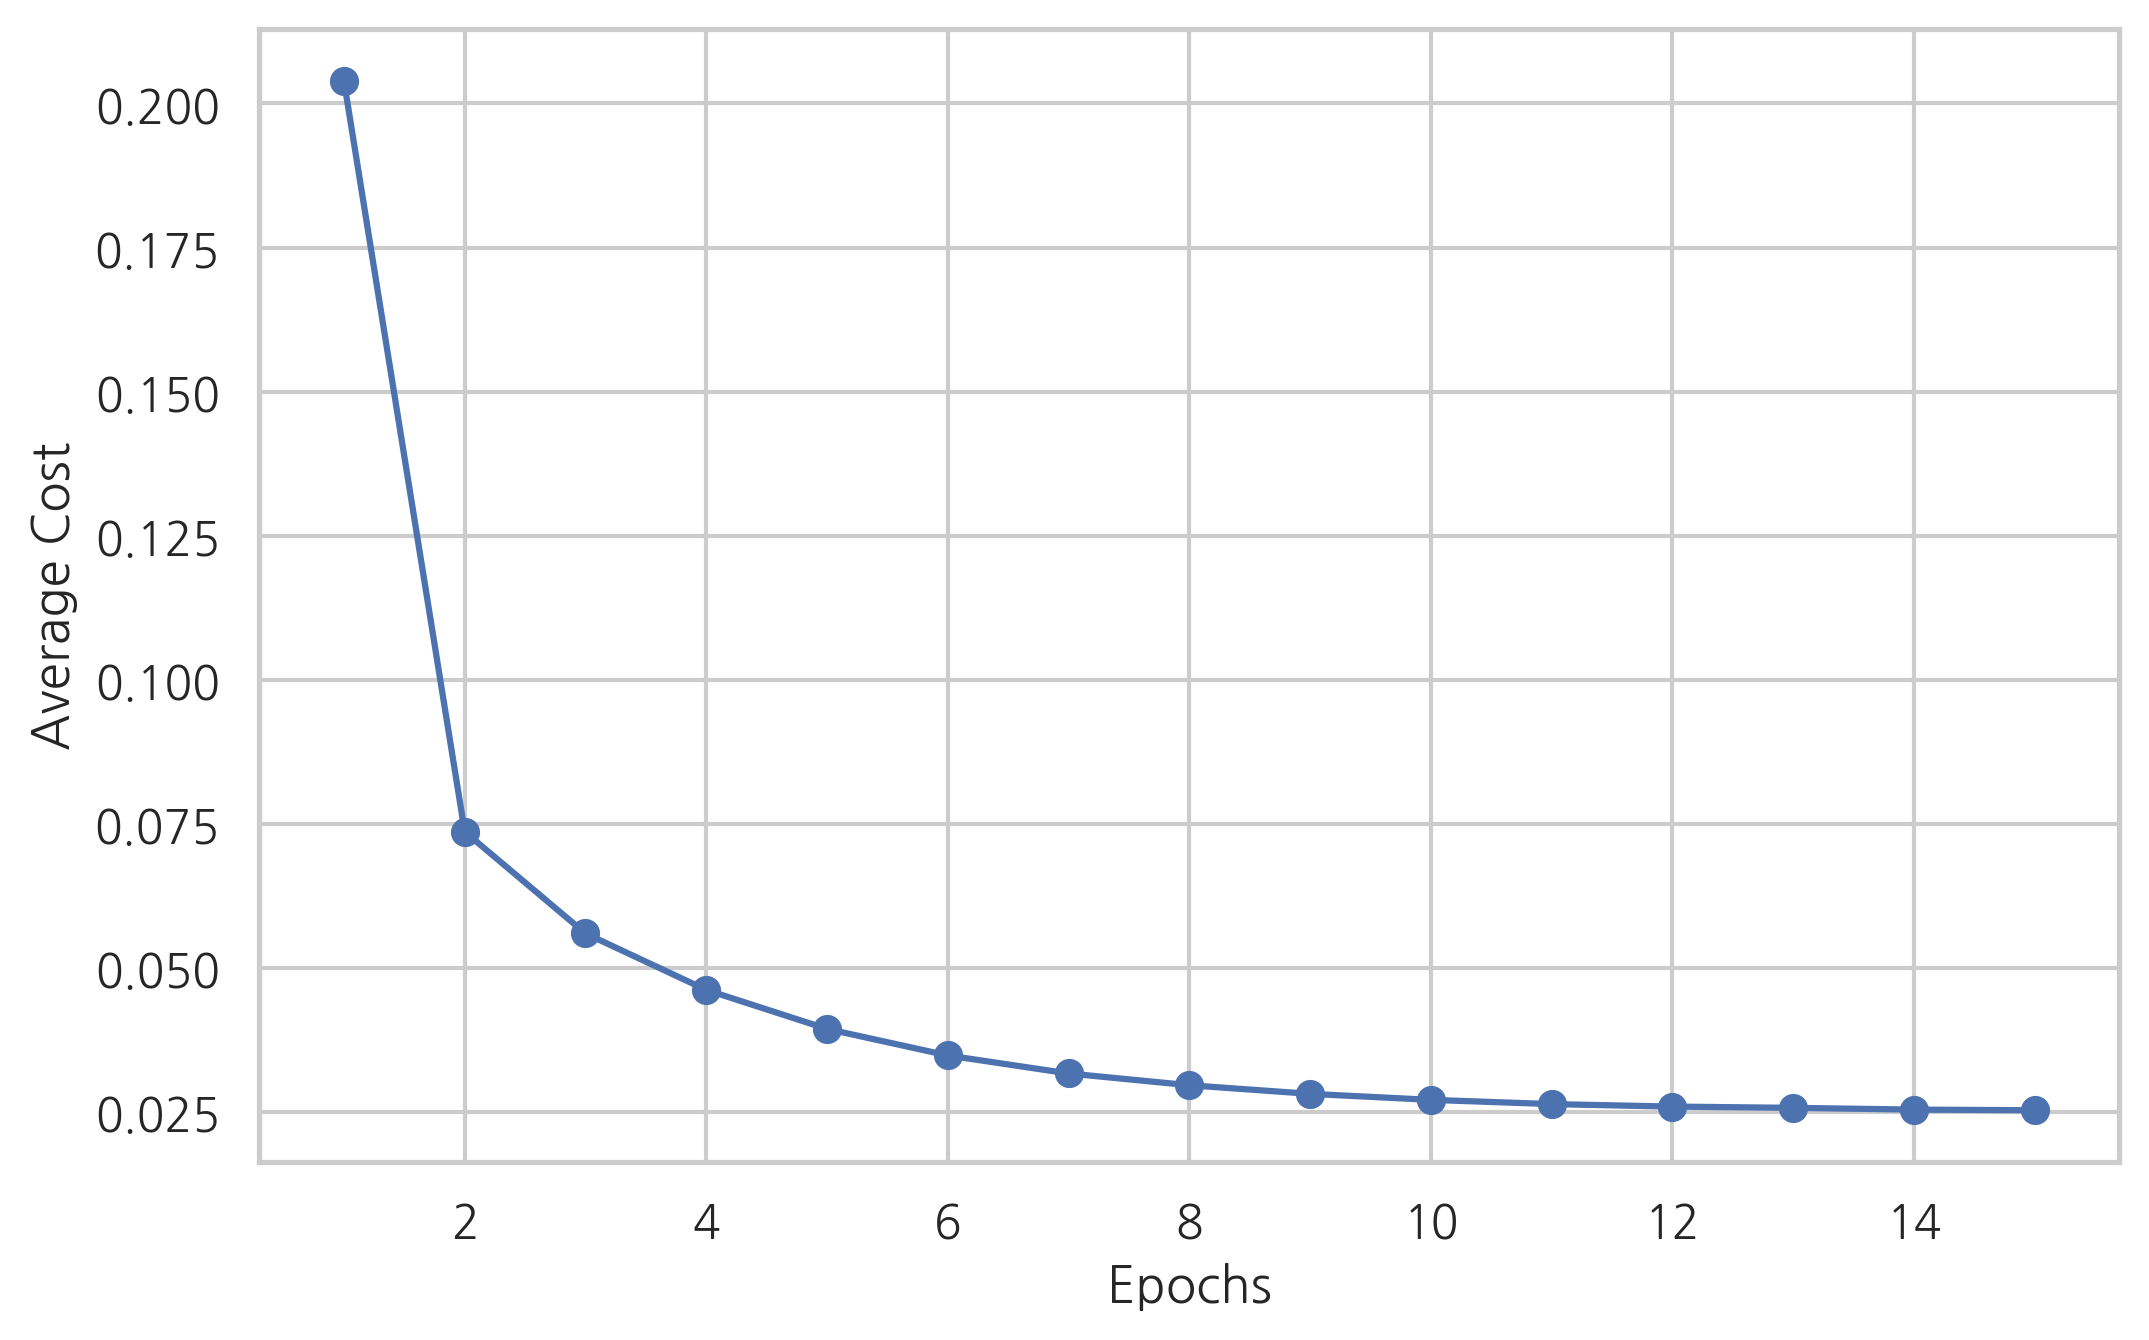

In [7]:
ada = AdalineSGD(n_iter=15, eta=0.01,random_state=1)
ada.fit(X_std,y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline- Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

In [12]:
rgen = np.random.RandomState(1)
w_ = rgen.normal(loc=0.0, scale=0.01,size=1 + X.shape[1])
for xi, target in zip(X, y):
    print(np.dot(xi,w_[1:]))

-0.03859398162784222
-0.037370468800542074
-0.03561878422097847
-0.0360633713118553
-0.03798222521419215
-0.04201376612558282
-0.03553519955959185
-0.038510396966455605
-0.0343116867322917
-0.037898640552805535
-0.04095742262105591
-0.03781505589141891
-0.036758712386892
-0.032115415061851255
-0.041819933018865836
-0.042792691862006134
-0.039901079116529
-0.03859398162784222
-0.04384903536653305
-0.039122153380105676
-0.04201376612558282
-0.039122153380105676
-0.033422512550538026
-0.04017849688463259
-0.03939957114820928
-0.039038568718719066
-0.039038568718719066
-0.03973390979375576
-0.039205738041492307
-0.037203299477768834
-0.03781505589141891
-0.04095742262105591
-0.03973390979375576
-0.04104100728244253
-0.037898640552805535
-0.03692588170966524
-0.04051283553017908
-0.037898640552805535
-0.03378351498002825
-0.039122153380105676
-0.0374540534619287
-0.03439527139367832
-0.03378351498002825
-0.039038568718719066
-0.041234840389159505
-0.036758712386892
-0.03965032513236914
-0.0

In [10]:
w_ 

array([ 0.01624345, -0.00611756, -0.00528172])